Скачаем данные.

In [ ]:
#!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


In [4]:
len(os.listdir('images/'))

7393

Посмотрим на изображения.

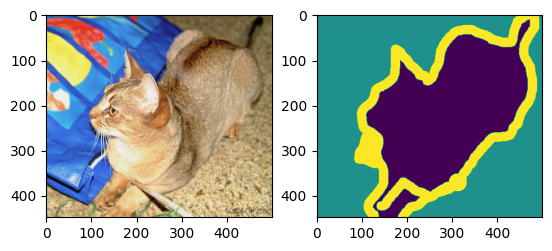

In [5]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

im = plt.imread(input_img_paths[9])
mask = plt.imread(target_img_paths[9])*255
fig,axes = plt.subplots(1,2)
axes[0].imshow(im)
axes[1].imshow(mask)

In [6]:
np.unique(mask)

array([1., 2., 3.], dtype=float32)

In [7]:
target_img_paths[0]

'annotations/trimaps/Abyssinian_1.png'

In [8]:
input_img_paths[0]

'images/Abyssinian_1.jpg'

Определим датасет + добавим стандартные трансформарции в пайплайн.

In [9]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch

class OxfordPetsDataset(Dataset):
    def __init__(self, input_img_paths, target_img_paths, img_size):
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = img_size
        self.input_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])
        self.target_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.Grayscale(),
            transforms.ToTensor(),
            lambda x: (x * 255).long().clamp(0, 2)  # Assuming labels are in [1,2,3], maps to [0,1,2]
        ])

    def __len__(self):
        return len(self.input_img_paths)

    def __getitem__(self, idx):
        input_img_path = self.input_img_paths[idx]
        target_img_path = self.target_img_paths[idx]
        
        input_img = Image.open(input_img_path).convert("RGB")
        target_img = Image.open(target_img_path).convert("L")
        
        input_img = self.input_transform(input_img)
        target_img = self.target_transform(target_img)

        return input_img, target_img

batch_size = 4
img_size = (160, 160) 
dataset = OxfordPetsDataset(input_img_paths, target_img_paths, img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Тензоры для input и target mask:

In [14]:
next(iter(dataloader))

[tensor([[[[0.7216, 0.7333, 0.7412,  ..., 0.7216, 0.7059, 0.6980],
           [0.7294, 0.7373, 0.7412,  ..., 0.7176, 0.7098, 0.7059],
           [0.7333, 0.7373, 0.7412,  ..., 0.7137, 0.7098, 0.7098],
           ...,
           [0.6431, 0.6510, 0.6196,  ..., 0.6157, 0.6157, 0.6157],
           [0.6431, 0.6431, 0.6588,  ..., 0.6196, 0.6157, 0.6157],
           [0.6353, 0.6392, 0.6549,  ..., 0.6275, 0.6235, 0.6235]],
 
          [[0.7294, 0.7412, 0.7490,  ..., 0.7373, 0.7255, 0.7176],
           [0.7451, 0.7490, 0.7490,  ..., 0.7333, 0.7294, 0.7255],
           [0.7529, 0.7569, 0.7529,  ..., 0.7294, 0.7294, 0.7294],
           ...,
           [0.6588, 0.6588, 0.6235,  ..., 0.6431, 0.6431, 0.6431],
           [0.6588, 0.6549, 0.6627,  ..., 0.6431, 0.6392, 0.6392],
           [0.6510, 0.6510, 0.6627,  ..., 0.6431, 0.6392, 0.6392]],
 
          [[0.7176, 0.7294, 0.7373,  ..., 0.7098, 0.6980, 0.6902],
           [0.7294, 0.7373, 0.7373,  ..., 0.7059, 0.7020, 0.6980],
           [0.7373, 0.74

In [11]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



Создадим простую матрицу.

In [14]:
np.array([[5, 7], [8, 11]])

array([[ 5,  7],
       [ 8, 11]])

И применим интерполяция методом ближайшего соседа.

In [19]:
import torch
import torch.nn.functional as F
import numpy as np

a = np.array([[5, 7], [8, 11]])
a_tensor = torch.tensor(a).float().unsqueeze(0).unsqueeze(0)  # Shape (1, 1, 2, 2)

upsampled_a_tensor = F.interpolate(a_tensor, scale_factor=(2, 2), mode='nearest')
upsampled_a_matrix = upsampled_a_tensor.squeeze().numpy()

print(upsampled_a_matrix)


[[ 5.  5.  7.  7.]
 [ 5.  5.  7.  7.]
 [ 8.  8. 11. 11.]
 [ 8.  8. 11. 11.]]


Определим архитектуру сети.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # Downsample Path
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding='same')
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.dropout = nn.Dropout(0.5)

        # Upsample Path
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(512, 256, kernel_size=3, padding='same')
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size=3, padding='same')

        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6_1 = nn.Conv2d(256, 128, kernel_size=3, padding='same')
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7_1 = nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, padding='same')

    def forward(self, x):
        # Downsample Path
        conv1 = F.relu(self.conv1_1(x))
        conv1 = F.relu(self.conv1_2(conv1))
        pool1 = self.pool1(conv1)

        conv2 = F.relu(self.conv2_1(pool1))
        conv2 = F.relu(self.conv2_2(conv2))
        pool2 = self.pool2(conv2)

        conv3 = F.relu(self.conv3_1(pool2))
        conv3 = F.relu(self.conv3_2(conv3))
        pool3 = self.pool3(conv3)

        # Bottleneck
        conv4 = F.relu(self.conv4_1(pool3))
        conv4 = F.relu(self.conv4_2(conv4))
        conv4 = self.dropout(conv4)

        # Upsample Path
        up5 = self.upconv5(conv4)
        up5 = torch.cat((up5, conv3), 1)
        conv5 = F.relu(self.conv5_1(up5))
        conv5 = F.relu(self.conv5_2(conv5))

        up6 = self.upconv6(conv5)
        up6 = torch.cat((up6, conv2), 1)
        conv6 = F.relu(self.conv6_1(up6))
        conv6 = F.relu(self.conv6_2(conv6))

        up7 = self.upconv7(conv6)
        up7 = torch.cat((up7, conv1), 1)
        conv7 = F.relu(self.conv7_1(up7))
        conv7 = F.relu(self.conv7_2(conv7))

        final_conv = self.final_conv(conv7)
        #out = F.softmax(final_conv, dim=1)
        return final_conv#out

num_classes = 3  
model = UNet(num_classes)


Определим train и test циклы.

In [81]:
import torch.optim as optim

model = UNet(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train():
    model.train()
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.squeeze(1).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    print(f"Train Average Loss: {avg_loss:.4f}")
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.squeeze(1).to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.nelement()
            
    
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100
    print(f"Test Average Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print('\n')

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train()
    test()

Train Average Loss: 0.5526
Test Average Loss: 0.4613
Test Accuracy: 76.9592


Train Average Loss: 0.4392
Test Average Loss: 0.4256
Test Accuracy: 79.9665


Train Average Loss: 0.4244
Test Average Loss: 0.4164
Test Accuracy: 80.5952


Train Average Loss: 0.4129
Test Average Loss: 0.4014
Test Accuracy: 81.4529


Train Average Loss: 0.3677
Test Average Loss: 0.3349
Test Accuracy: 85.3122


Train Average Loss: 0.3156
Test Average Loss: 0.3089
Test Accuracy: 86.6592


Train Average Loss: 0.2845
Test Average Loss: 0.2773
Test Accuracy: 88.3747


Train Average Loss: 0.2578
Test Average Loss: 0.2500
Test Accuracy: 89.4905


Train Average Loss: 0.2445
Test Average Loss: 0.2390
Test Accuracy: 89.9529


Train Average Loss: 0.2318
Test Average Loss: 0.2299
Test Accuracy: 90.1040




In [31]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.squeeze(1).to(device)
        output = model(data)

Посмотрим на предсказания.

Text(0.5, 1.0, 'Image')

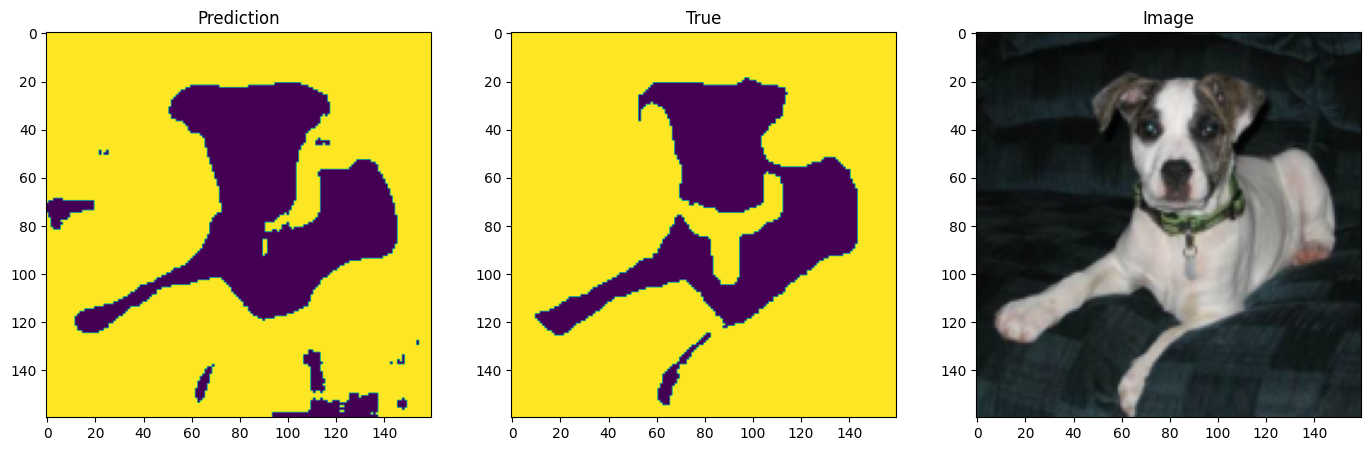

In [79]:
fig, axes = plt.subplots(1,3,figsize=(17,5))
index = 5
mask = output[index].cpu().numpy()
mask = np.argmax(mask,axis=0)
axes[0].imshow(mask)
axes[0].set_title('Prediction')
axes[1].imshow(target[index].cpu().numpy())
axes[1].set_title('True')
axes[2].imshow(np.moveaxis(data[index].cpu().numpy(),0,-1))
axes[2].set_title('Image')